# Uploading files from local PC
Files to upload:

1.  FaceNet weights
2.  train_final.pickle
3.  test_final.zip
4.  fr_utils
5.  inception_blocks_v2 



In [2]:
from google.colab import files

uploaded = files.upload()

Saving train_final.pickle to train_final.pickle
Saving test_final.zip to test_final.zip
Saving inception_blocks_v2.py to inception_blocks_v2.py
Saving fr_utils.py to fr_utils.py


In [0]:
!unzip -q test_final.zip
# !unzip -q weights.zip

# Importing dependencies

In [1]:
import numpy as np
import cv2
import pickle
import os
import matplotlib.pyplot as plt
import argparse
import random
from itertools import permutations
import os
from numpy import genfromtxt
import pandas as pd
from fr_utils import *
from inception_blocks_v2 import *

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

K.set_image_data_format('channels_first')

In [3]:
## For making some older version syntax in tf work ##

import keras.backend.tensorflow_backend as tfback
import tensorflow as tf

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [0]:
## Loading pickled data that contains the train images stacked as per classes##

with open('train_final.pickle', 'rb') as f:
    data, _ = pickle.load(f)

In [5]:
data.shape

(24, 30, 3, 96, 96)

# Triplet generator
The following function will generate triplet of images from the unpicked stack on which Siamese Network will train on. Triplets will have an **Anchor**, a **positive** and a **negative** image. 

In [0]:
def generate_triplet(x, ap_pairs = 10, an_pairs = 10, test_size = 0.3):
    
    test_triplets = []
    train_triplets = []

    for cls in range(x.shape[0]):
        positive_pairs = random.sample(list(permutations(range(x.shape[1]), 2)), k=ap_pairs)
        
        l = []
        for i in range(0, x.shape[0]*x.shape[1]):
            if i not in range(cls*x.shape[1], (cls+1)*x.shape[1]):
                l.append(i)
        
        abs_index = np.random.choice(l, size=(an_pairs,), replace=False)
        n_classes = np.array([[i//x.shape[1], i%x.shape[1]] for i in abs_index])
        # the triplets

        p_len = len(positive_pairs)

        for pair in positive_pairs[:int((1-test_size)*p_len)]:
            anchor = x[cls, pair[0],]
            positive = x[cls, pair[1],]
            
            for n in range(an_pairs):
                negative = x[n_classes[n][0], n_classes[n][1]]
                train_triplets.append([anchor, positive, negative])
        
        for pair in positive_pairs[int((1-test_size)*p_len):]:
            anchor = x[cls, pair[0],]
            positive = x[cls, pair[1],]
            
            for n in range(an_pairs):
                negative = x[n_classes[n][0], n_classes[n][1]]
                test_triplets.append([anchor, positive, negative])
                
    return np.array(train_triplets), np.array(test_triplets) 

In [7]:
X_train, X_val = generate_triplet(data, ap_pairs=23, an_pairs=23, test_size=0.2)
print(X_train.shape, X_val.shape)

(9936, 3, 3, 96, 96) (2760, 3, 3, 96, 96)


# Visualizing a 'Triplet'

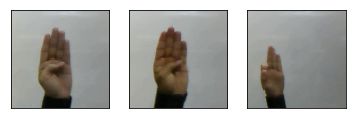

In [40]:
inx = 2345
img = X_train[inx].copy()
imgf = []
for i in range(3):
    img[i] = img[i][...,::-1]
    imgf.append(np.transpose(img[i], (1,2,0)))

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.matshow(imgf[0])

ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

ax2.matshow(imgf[1])
ax3.matshow(imgf[2])
plt.xticks([])
plt.yticks([])
plt.show()

# Base ConvNet
The following function loads the base pretrained ConvNet, that is going to extract features from the input images.<br>
We have 2 options:
1. Pretrained FaceNet
2. VGG16

VGG16 works better as far as this ASL dataset is concerned.

In [0]:
def create_base_network(input_shape, network = 'FaceNet', trainable = 12):
    if network == 'FaceNet':        
        model = faceRecoModel(input_shape=input_shape)
        load_weights_from_FaceNet(model)

        for layer in model.layers[:-trainable]:
            layer.trainable = False
    else:
        from keras.applications import VGG16

        base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        base.trainable = False
        model = Sequential()
        model.add(base)
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64))

    return model

# Triplet Loss
For one-shot learning

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)
 
    return loss

In [0]:
input_shape = (3,96,96)
base_net = 'VGG16'

# Defining the network

In [13]:
# Shared embedding layer for positive and negative items
shared_dnn = create_base_network(input_shape, base_net)

anchor_input = Input(input_shape, name='anchor_input')
positive_input = Input(input_shape, name='positive_input')
negative_input = Input(input_shape, name='negative_input')

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

checkpoint = ModelCheckpoint('final_weights_{}.h5'.format(base_net), verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
# model-{epoch:03d}-{acc:03f}-{val_acc:03f}
merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)

optimizer = Adam(lr=0.0005)
model.compile(loss=triplet_loss, optimizer=optimizer, metrics=['accuracy'])

y_pred.shape =  Tensor("merged_layer/concat:0", shape=(None, 192), dtype=float32)


In [14]:
print(model.count_params())
model.summary()

15312896
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           15312896    anchor_input[0][0]               
                                                                 positive_input[0][

# Seperating
Seperating the triplets so that we can feed it to the model

In [15]:
np.random.shuffle(X_train)
np.random.shuffle(X_val)

Anchor = X_train[:,0,:]
Positive = X_train[:,1,:]
Negative = X_train[:,2,:]
Anchor_test = X_val[:,0,:]
Positive_test = X_val[:,1,:]
Negative_test = X_val[:,2,:]

print(Anchor.shape)
Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

(9936, 3, 96, 96)


# Fitting model on the data

1. Only training the extra layers of VGG16 (it works better than the pretrained FaceNet network)


In [16]:
model.fit([Anchor,Positive,Negative],
          y=Y_dummy,
          validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint])

Train on 9936 samples, validate on 2760 samples
Epoch 1/5
9936/9936 [==============================] - 47s 5ms/step - loss: 0.0249 - accuracy: 0.0000e+00 - val_loss: 0.0180 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.01802, saving model to final_weights_VGG16.h5
Epoch 2/5
9936/9936 [==============================] - 44s 4ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.0173 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.01802 to 0.01732, saving model to final_weights_VGG16.h5
Epoch 3/5
9936/9936 [==============================] - 44s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.01732 to 0.01696, saving model to final_weights_VGG16.h5
Epoch 4/5
9936/9936 [==============================] - 44s 4ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss improved from 0.01696 to 0.01267, sav

2. Now fine-tuning the whole model after setting all layers trainable.

In [17]:
for l in shared_dnn.layers:
    l.trainable = True
model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
# model.trainable = True

optimizer = Adam(lr=0.0001)
model.compile(loss=triplet_loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

y_pred.shape =  Tensor("merged_layer/concat:0", shape=(None, 192), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           15312896    anchor_input[0][0]               
          

In [18]:
checkpoint2 = ModelCheckpoint('final_finetune_weights_{}.h5'.format(base_net), verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit([Anchor,Positive,Negative],
          y=Y_dummy,
          validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint2])

Train on 9936 samples, validate on 2760 samples
Epoch 1/5
9936/9936 [==============================] - 106s 11ms/step - loss: 0.0218 - accuracy: 0.0000e+00 - val_loss: 0.0097 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00974, saving model to final_finetune_weights_VGG16.h5
Epoch 2/5
9936/9936 [==============================] - 103s 10ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00974 to 0.00421, saving model to final_finetune_weights_VGG16.h5
Epoch 3/5
9936/9936 [==============================] - 103s 10ms/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.00421
Epoch 4/5
9936/9936 [==============================] - 104s 10ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0134 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00421
Epoch 5/5
9936/9936 [=====

# Loading the best network weights

In [0]:
FRmodel = Model(inputs=anchor_input, outputs=encoded_anchor)

FRmodel.load_weights('final_finetune_weights_{}.h5'.format(base_net))

# Defining test functions

In [0]:
def who_is_it(image_path, database, model):
    '''
    Outputs the class closest to the image addressed by the input_path, by calculating the minimum of L2 norms
    of the differences between encodings of this image with the each class representative images
    '''
    encoding = img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():
        dist = np.linalg.norm(db_enc - encoding)
        if dist < min_dist:
            min_dist = dist
            identity = name
        
    return min_dist, identity

In [0]:
def test_accuracy(path, database, model):
    '''
    This function goes through all the images in the directory given by the path, and checks whether it is the 
    correct class as given by the subfolder of the directory or not.
    '''
    correct = 0
    total = 0
    for cls in os.listdir(path):
        subpath = os.path.join(path, cls)
        for image in os.listdir(subpath):
            total += 1
            image_path = os.path.join(subpath, image)
            dist, iden = who_is_it(image_path, database, model)

            if(iden == cls):
                correct += 1

    return (correct/total)*100, correct, total

# Test Accuracy

In [0]:
## Storing the class representative image encodings in the database ##
database = {}

test_dir = "/content/ASL_test" 
for cls in os.listdir(test_dir):
    image1 = os.listdir(os.path.join(test_dir, cls))[3]
    path = os.path.join(test_dir, cls, image1)
    database[cls] = img_to_encoding(path, FRmodel)

In [32]:
print(test_accuracy('ASL_test', database, FRmodel))

(85.83333333333333, 206, 240)


# Downloading the best weights

In [33]:
from google.colab import files
files.download('/content/final_finetune_weights_VGG16.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 57868, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil